In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
import datetime
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = {}
for i in range(len(root_tweet_names)):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce', downcast='integer')
    
    tweet_dfs[i] = tweet_df

In [4]:
tweet_name_to_index = {}
for i in range(len(root_tweet_names)):
    tweet_name_to_index[root_tweet_names[i]] = i
# for key in tweet_name_to_index.keys():
#     print key

In [5]:
def format_partition_file_name(name):
    root = name.split('.')
    items = root[0].split('_')
    items[-2], items[-1] = items[-1], items[-2]
    return ".".join(["_".join(items), root[-1]])

In [8]:
path = '../RetweetDataAOAS/Partition/'
partition_names = [f for f in listdir(path) if isfile(join(path, f))]
partitions = {}
# for i in range(len(partition_names)):
for i in range(1, 2):
    partitions[i] = {}
    print i
    partition_df = pd.read_excel(path+partition_names[i], encoding = "ISO-8859-1")
    for index, row in partition_df.iterrows():
        training_file_name = format_partition_file_name(row['Training'])
        prediction_file_name = format_partition_file_name(row['Prediction'])
        print "\n", training_file_name
        print prediction_file_name
        partitions[i][tweet_name_to_index[training_file_name]] = True
        partitions[i][tweet_name_to_index[prediction_file_name]] = False    

1

Source_followers_tweet_0022_Lawrence.txt
Source_followers_tweet_0024_pbsgwen.txt

Source_followers_tweet_0026_realMickFoley.txt
Source_followers_tweet_0028_AnnCoulter.txt

Source_followers_tweet_0031_ASAPYams.txt
Source_followers_tweet_0031_CNET.txt

Source_followers_tweet_0037_EvaLongoria.txt
Source_followers_tweet_0044_JonnyBones.txt

Source_followers_tweet_0048_MissInfoTV.txt
Source_followers_tweet_0068_CharlesMBlow.txt

Source_followers_tweet_0069_bobatl.txt
Source_followers_tweet_0070_E40.txt

Source_followers_tweet_0074_Tip.txt
Source_followers_tweet_0074_iamwill.txt

Source_followers_tweet_0085_MrChuckD.txt
Source_followers_tweet_0091_CharlesMBlow.txt

Source_followers_tweet_0092_AnnCoulter.txt
Source_followers_tweet_0092_jasonsegel.txt

Source_followers_tweet_0101_GarryShandling.txt
Source_followers_tweet_0101_Pitbull.txt

Source_followers_tweet_0101_myfabolouslife.txt
Source_followers_tweet_0107_djkhaled.txt

Source_followers_tweet_0108_newtgingrich.txt
Source_followers_twe

In [9]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

# modify the dfs accordingly
for i in range(len(root_tweet_names)):
    for index, row in tweet_dfs[i].iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_dfs[i].at[row['ParentDfIndex'],
                                                      'Time']
            tweet_dfs[i].loc[index,"ReactionTime"] = reaction_time
        else:
            tweet_dfs[i].loc[index,"ReactionTime"] = datetime.timedelta(seconds=0)

In [10]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet
        

In [11]:
tweet_df_1 = tweet_dfs[1]
s_j_x = sorted(generate_reaction_times(tweet_df_1).values())
log_s_j_x = [np.log(i.seconds) for i in s_j_x]
tweet_df_1_users = list(tweet_df_1['UserId'])
m_j_x_dic = generate_number_of_follower_who_retweet(tweet_df_1)
m_j_x_lis = []
for key in m_j_x_dic.keys():
    m_j_x_lis.append(m_j_x_dic[key])

In [12]:
def get_m_x_t(x,sec):
    return len(tweet_dfs[x].loc[tweet_dfs[x]["ReactionTime"] < datetime.timedelta(seconds=sec)])

In [13]:
len(tweet_dfs[0])

74

In [17]:
# linear regression model setup

time_train = {} #key is time, value is a dictionary
retweets_train = {}
time_test = {}
retweets_test = {}

t = []
m_x_t = []
M_x = []


for i in range(1,14):
    secs = int(np.floor(np.exp(i)))
#     for x in range(len(root_tweet_names)):
    for x in range(2):
        total_retweets = len(tweet_dfs[x])-1
        t.append(i)
        m_x_t.append(get_m_x_t(x,secs))
        M_x.append(total_retweets)

t = np.array(t)
m_x_t = np.array(m_x_t)
m_x_t_log = np.log(m_x_t)
M_x_log = np.log(np.array(M_x))

# for i in range(len(root_tweet_names)):
#     # todo: need to do train / test split
#     count = int(tweet_dfs[i].iloc[0]["FollowerCount"])
#     if partitions[1][i]: # currently hard-coded to look at first partition
#         followers_train.append(count)
#         retweets_train.append(len(tweet_dfs[i]) - 1) 
#     else:
#         followers_test.append(count)
#         retweets_test.append(len(tweet_dfs[i]) - 1) 

# followers_train_log = np.log(np.array(followers_train))
# retweets_train_log = np.log(np.array(retweets_train))

# followers_test_log = np.log(np.array(followers_test))
# retweets_test_log = np.log(np.array(retweets_test))

# data = dict(x = followers_train_log, y = retweets_train_log)

In [18]:
# Szabo and Huberman: log(M^x) = beta(t) + log(m^x(t)) + e^x

with pm.Model() as regression_model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_t = pm.Normal('beta_t', 0, sd=20, shape = (len(t),1))
        
    e_x = pm.Normal("e", 0, sd = 1, shape = (len(t),1))

    # Define likelihood    
    likelihood = pm.Normal('y', mu=beta_t + m_x_t_log + e_x,
                        sd=sigma, observed=M_x_log)

In [19]:
# Run and fit our model
with regression_model:
#     step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e, beta_t, sigma_log__]
100%|██████████| 2000/2000 [00:32<00:00, 61.18it/s]


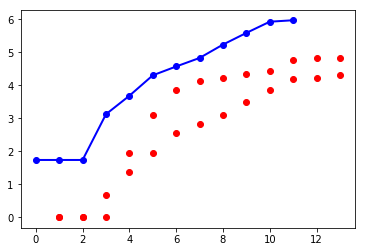

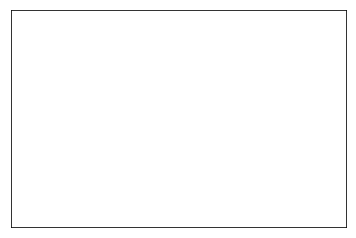

In [28]:
# Plot outputs

plt.scatter(t, m_x_t_log,  color='red')

b_t = np.mean(trace['beta_t'])
# b_1 = np.mean(trace['beta_1'])
x_line = [i for i in range(12)]
y_line = []
for val in x_line:
    y_line.append(b_t + m_x_t_log[2*val])

plt.plot(x_line, y_line, 'bo-', label='line 1', linewidth=2)
fig, ax = plt.subplots()

plt.xticks(())
plt.yticks(())

plt.show()

In [25]:
t

array([ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 11, 11, 12, 12, 13, 13])

1.74235836246


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff470050510>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff45f6015d0>]], dtype=object)

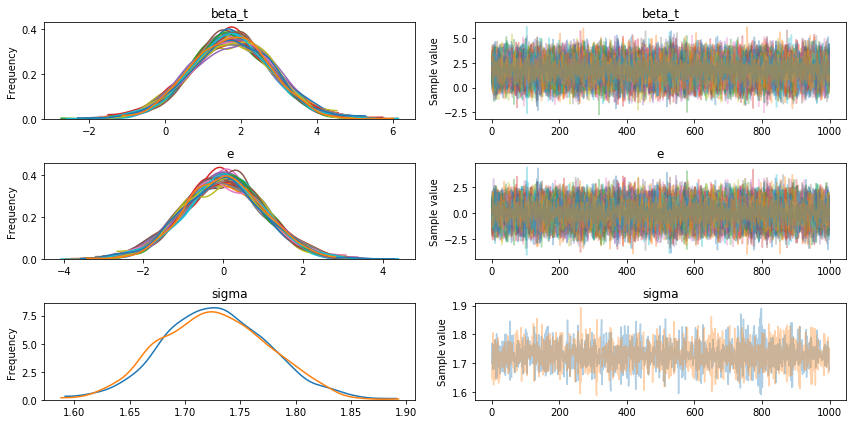

In [24]:
print np.mean(trace['beta_t'])
pm.traceplot(trace)